In [1]:
# import all the dependecies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load the data 
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

# Dictionary to hold dataframes
df = {}
for ticker in tickers:
    df[ticker] = pd.read_csv(f'../data/yfinance_data/{ticker}_historical_data.csv',parse_dates=['Date'])


In [3]:
df = df['AAPL']

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600,0.0,0.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600,0.0,0.0


In [5]:
df.shape

(10998, 9)

In [6]:
import talib

df = df.set_index('Date')

# Ensure necessary columns are numeric (float for TA-Lib)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)


--- DataFrame with TA-Lib Indicators (Tail) ---
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-24  224.000000  224.800003  217.130005  218.539993  218.287323   
2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   

                Volume  Dividends  Stock Splits      SMA_20      SMA_50  \
Date                                                                      
2024-07-24  61777600.0        0.0           0.0  224.228500  208.474199   
2024-07-25  51391200.0        0.0           0.0  224.440500  209.098399   
2024-07-26  41601300.0        0.0           0.0  224.633500  209.709000   
2024-07-29  36311800.0        0.0           0.0  225.0145

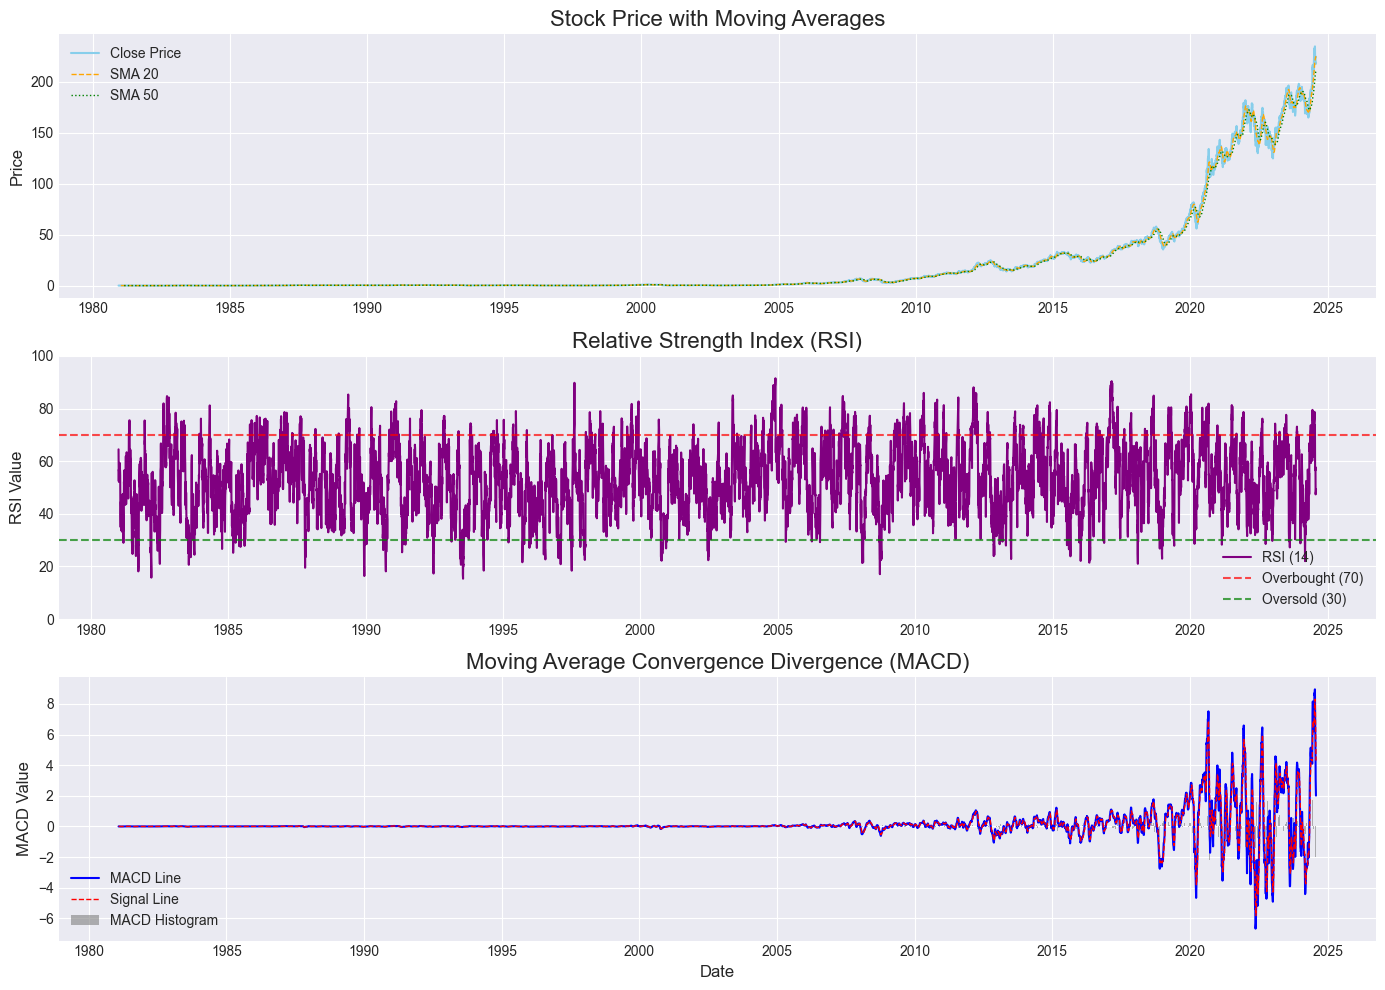

In [8]:
# Calculate Simple Moving Average (SMA)
# SMA 20 (20-period SMA)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
# SMA 50 (50-period SMA)
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)

# Calculate Relative Strength Index (RSI)
# RSI 14 (14-period RSI)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
# Default periods: fastperiod=12, slowperiod=26, signalperiod=9
macd, macdsignal, macdhist = talib.MACD(df['Close'],
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACD_Signal'] = macdsignal
df['MACD_Hist'] = macdhist

print("\n--- DataFrame with TA-Lib Indicators (Tail) ---")
# Note: Indicators will have NaN values at the beginning due to the calculation window.
print(df.tail())

# --- 3. Use Pandas for Financial Metrics ---

# Calculate Daily Returns
# Using 'Close' price for daily returns, but 'Adj Close' is often preferred for real analysis
df['Daily_Return'] = df['Close'].pct_change()

# Calculate Cumulative Returns
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1

# Calculate Volatility (20-day rolling standard deviation of daily returns)
# Annualized by multiplying by sqrt(252) for ~252 trading days in a year
df['Volatility_20D'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

print("\n--- DataFrame with Financial Metrics (Tail) ---")
print(df.tail())

# --- 4. Visualize the Data ---

# Set up plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 10))

# Plot 1: Close Price with SMAs
plt.subplot(3, 1, 1) # 3 rows, 1 column, first plot
plt.plot(df.index, df['Close'], label='Close Price', color='skyblue', linewidth=1.5)
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='orange', linestyle='--', linewidth=1)
plt.plot(df.index, df['SMA_50'], label='SMA 50', color='green', linestyle=':', linewidth=1)
plt.title('Stock Price with Moving Averages', fontsize=16)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

# Plot 2: Relative Strength Index (RSI)
plt.subplot(3, 1, 2) # Second plot
plt.plot(df.index, df['RSI'], label='RSI (14)', color='purple', linewidth=1.5)
plt.axhline(70, linestyle='--', color='red', alpha=0.7, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', alpha=0.7, label='Oversold (30)')
plt.title('Relative Strength Index (RSI)', fontsize=16)
plt.ylabel('RSI Value', fontsize=12)
plt.ylim(0, 100) # RSI ranges from 0 to 100
plt.legend()
plt.grid(True)

# Plot 3: Moving Average Convergence Divergence (MACD)
plt.subplot(3, 1, 3) # Third plot
plt.plot(df.index, df['MACD'], label='MACD Line', color='blue', linewidth=1.5)
plt.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red', linestyle='--', linewidth=1)
# MACD Histogram is typically plotted as bars
plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.6)
plt.title('Moving Average Convergence Divergence (MACD)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

# Overall Summary

The graphs collectively paint a picture of a stock that experienced a very long period of dormancy or very low value, followed by a dramatic and sustained bullish trend starting around 2015. All three indicators (SMAs, RSI, and MACD) consistently reflect this strong upward momentum during the latter period, providing confirming signals of the trend's strength.